In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

2025-02-17 15:48:55.632836: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 15:48:55.635702: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 15:48:55.641851: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 15:48:55.663988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739807335.685886   40173 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739807335.69

2025-02-17 15:48:58.821191: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


Example 1 - Image shape: (256, 256, 3)


2025-02-17 15:48:59.390333: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Example 1 - Label =  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Example 1 - Mask shape: (256, 256, 1)


Example 2 - Image shape: (256, 256, 3)
Example 2 - Label =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Example 2 - Mask shape: (256, 256, 1)




2025-02-17 15:48:59.693246: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


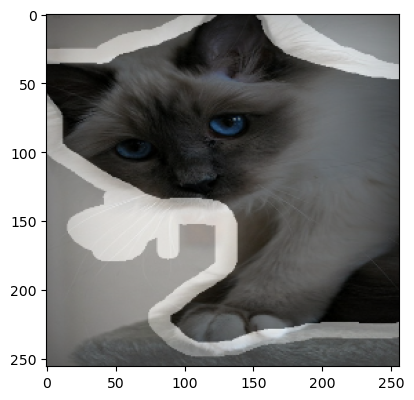

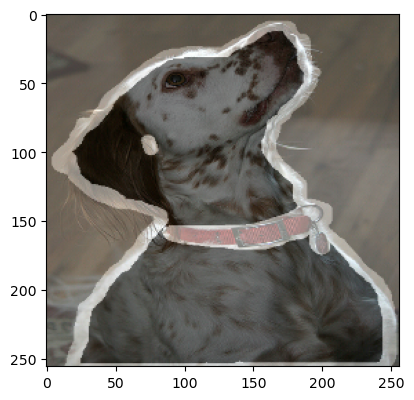

In [2]:
from data_loading import OxfordPetDataset
from augmentation import random_flip, augmentation_layers_geometric, augmentation_layers_color
from models import UNet_model, Autoencoder #2.a, 2.b exercises
from experiment import plot_results

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (256, 256)
dataset.res_norm(reshape_size)

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

print("\n")

for i, example in enumerate(train.take(2)):  # Take two examples
    print(f"Example {i+1} - Image shape:", example['image'].shape)
    image = example['image']
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    label = example['label']
    print(f"Example {i+1} - Label = ", label.numpy())
    mask = example['segmentation_mask']  # This is the segmentation mask
    plt.imshow(mask, cmap='gray', alpha=0.5)
    print(f"Example {i+1} - Mask shape:", mask.numpy().shape)
    print("\n")
plt.show()

In [3]:
train

<_MapDataset element_spec={'image': TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(37,), dtype=tf.float32, name=None), 'segmentation_mask': TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)}>

In [4]:
augmentation_color = augmentation_layers_color()
augmentation_geometric = augmentation_layers_geometric()

2025-02-17 15:49:00.847120: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


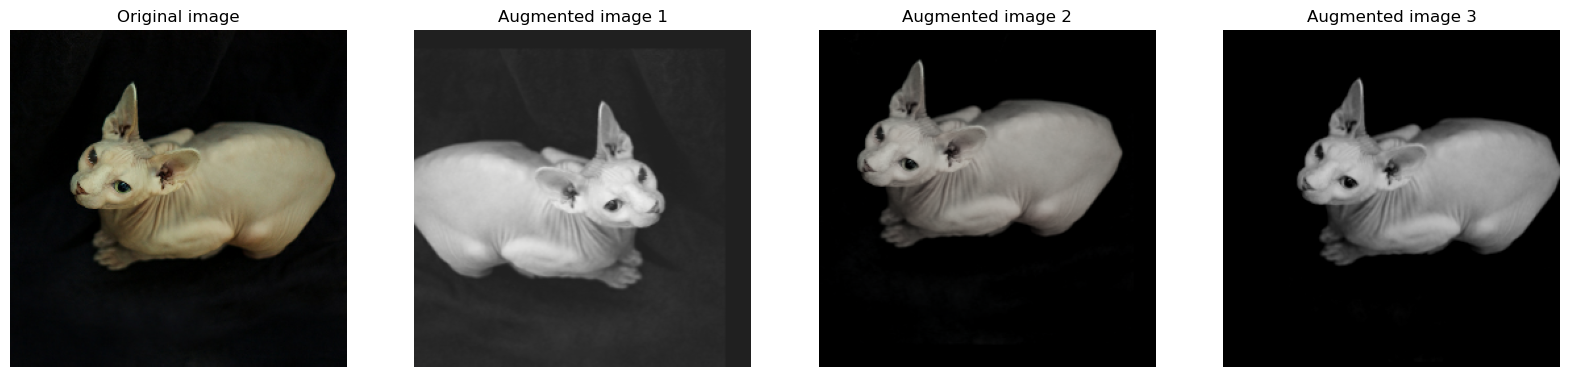

In [5]:
for example in train.take(1):
    image = example['image']
    
    plt.figure(figsize=(20, 5))
    
    # Plot original image
    plt.subplot(1, 4, 1)
    plt.title("Original image")
    plt.imshow(image)
    plt.axis("off")
    
    # Plot augmented images
    for i in range(3):
        aug_img = augmentation_geometric(tf.expand_dims(image, axis=0))
        aug_img = augmentation_color(aug_img)
        plt.subplot(1, 4, i+2)
        plt.title(f"Augmented image {i+1}")
        plt.imshow(aug_img[0])
        plt.axis("off")

plt.show()

From now on we want all datasets to be lists of just images and masks

In [ ]:
def extract_image_mask(data):
    """Extract image and mask from dictionary"""
    return data['image'], data['image']

# Apply to all datasets
train = train.map(extract_image_mask)
val = val.map(extract_image_mask)
test = test.map(extract_image_mask)



In [7]:
def augment_image_mask(image, mask):
    # Add batch dimension (from (H,W,C) to (1,H,W,C)
    batched_image = tf.expand_dims(image, axis=0)
    batched_mask = tf.expand_dims(mask, axis=0)
    
    # Apply color augmentation to image only
    aug_image = augmentation_color(batched_image, training=True)
    
    # Combine image+mask for geometric augmentations
    combined = tf.concat([aug_image, batched_mask], axis=-1)
    combined = augmentation_geometric(combined, training=True)
    
    # Split back and remove batch dimension
    aug_image, aug_mask = tf.split(combined, [3, tf.shape(batched_mask)[-1]], axis=-1)
    return tf.squeeze(aug_image, axis=0), tf.squeeze(aug_mask, axis=0)

# Apply augmentations to training data only
train = train.map(augment_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
BATCH_SIZE = 4

# Batch the data and use prefetching to optimize loading speed
train_ds = train.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
# Initialize and compile model
model = Autoencoder(input_shape=reshape_size + (3,))
model.compile(optimizer='adam', 
              loss='mse', #to be checked
              metrics=['accuracy'])

/home/noxiusk/miniconda3/envs/mlp/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(train_ds, epochs=2, validation_data=val_ds)

# Save trained model
model.save("autoencoder_model.h5")
 
# Save encoder separately
encoder = model.encoder
encoder.save("encoder_model.h5")

Epoch 1/2


2025-02-17 15:49:06.564028: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


 15/828 ━━━━━━━━━━━━━━━━━━━━ 19:15 1s/step - accuracy: 0.0700 - loss: 0.0726

KeyboardInterrupt: 

In [ ]:
num_samples = 5
sample_images = val_ds[:num_samples]
reconstructed_images = model.predict(sample_images)
 
# Plot original and reconstructed images
fig, axes = plt.subplots(num_samples, 2, figsize=(6, num_samples * 2))
for i in range(num_samples):
    axes[i, 0].imshow(sample_images[i])
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(reconstructed_images[i])
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis("off")
 
plt.tight_layout()
plt.show()